In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import load_breast_cancer
from sklearn import set_config


set_config(display="diagram")

In [19]:
cancer = load_breast_cancer(as_frame=True)
df = cancer.frame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [20]:
df['target'] = np.where(df['target'] == 0, 'malignant', 'benign')

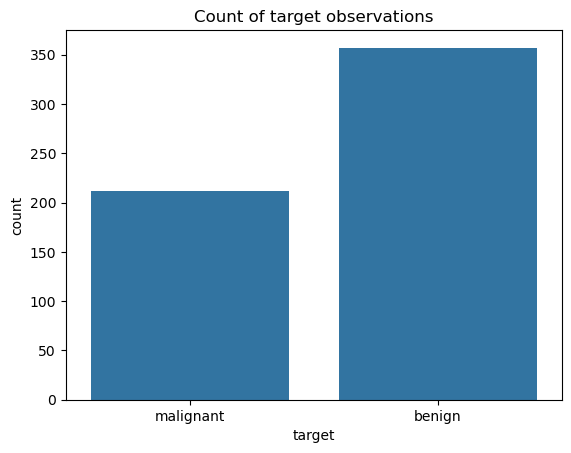

In [21]:
sns.countplot(data=df, x = 'target')
plt.title('Count of target observations');

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df.target, 
                                                    random_state = 42,
                                                   stratify = df.target)

In [23]:
y_test.value_counts(normalize = True)


target
benign       0.629371
malignant    0.370629
Name: proportion, dtype: float64

In [24]:
y_train.value_counts(normalize = True)


target
benign       0.626761
malignant    0.373239
Name: proportion, dtype: float64

In [25]:

knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 10))])
knn_pipe.fit(X_train, y_train)

knn_pipe

Pipeline(steps=[('scale', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=10))])

In [26]:
knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 10))])
knn_pipe.fit(X_train, y_train)
min_fp = precision_score(y_test, knn_pipe.predict(X_test), pos_label = 'malignant')

min_fp

0.9795918367346939

In [27]:
target_map = {'malignant': 1, 'benign': 0}

y_train_numeric = y_train.map(target_map)
y_test_numeric = y_test.map(target_map)
recall_grid = GridSearchCV(knn_pipe, param_grid = {'knn__n_neighbors': range(1, 23, 2)},
                   scoring = 'recall')
recall_grid.fit(X_train, y_train_numeric)
best_score = recall_grid.score(X_test, y_test_numeric)


print(f'The best recall score is: {best_score: .2f}')

The best recall score is:  0.89


In [28]:

recall_preds = recall_grid.predict(X_test)
fn = 0
tp = 0
for i,j in zip(recall_preds, y_test_numeric):
    if i == 0 and j == 1:
        fn += 1
    if i == 1 and j == 1:
        tp += 1


### ANSWER CHECK
print(f'Recall by hand is: {tp/(tp + fn): .2f}')

Recall by hand is:  0.89


In [29]:
cancer_x, cancer_y = cancer.data, cancer.target
cancer_x_train, cancer_x_test, cancer_y_train, cancer_y_test = train_test_split(cancer_x, cancer_y, random_state=42)

In [30]:
cancer_pipeline = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier())])
cancer_pipeline.fit(cancer_x_train, cancer_y_train)
cancer_preds = cancer_pipeline.predict(cancer_x_test)

cancer_pipeline

Pipeline(steps=[('scale', StandardScaler()), ('knn', KNeighborsClassifier())])

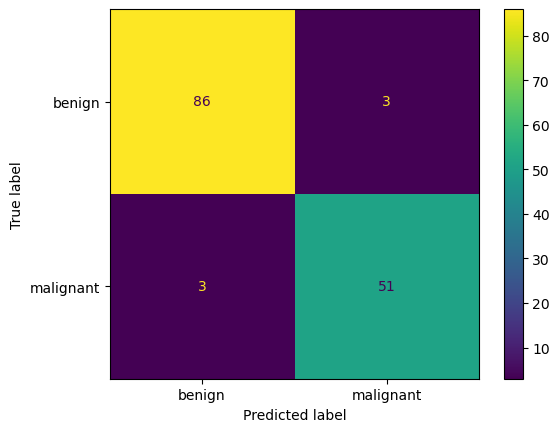

In [31]:
cancer_confusion_mat = confusion_matrix(cancer_y_test, cancer_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cancer_confusion_mat, display_labels=['benign', 'malignant' ])
disp.plot()
plt.show()

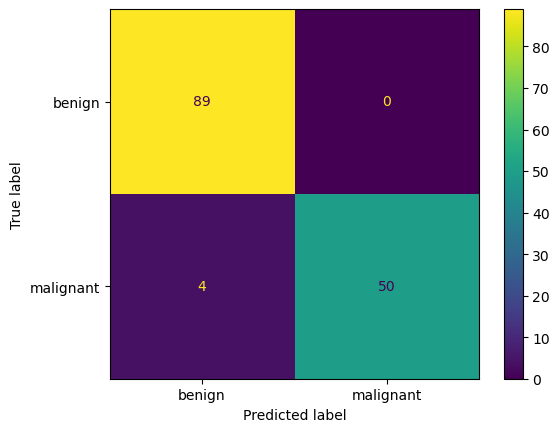

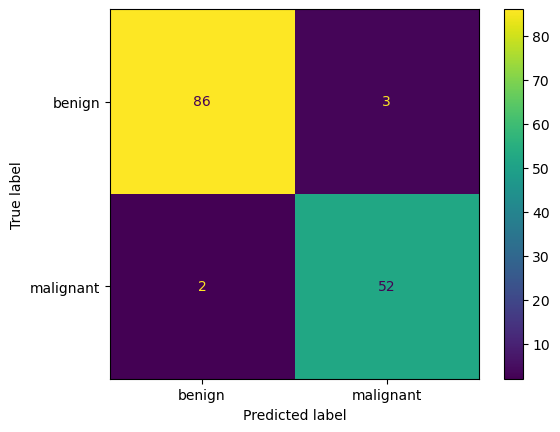

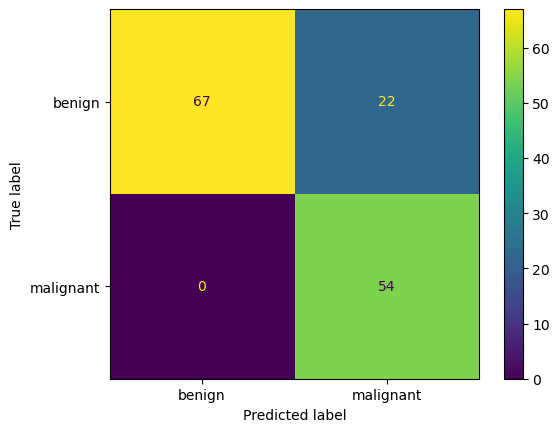

In [48]:
knn_ex = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors = 10))])
knn_ex.fit(cancer_x_train, cancer_y_train)
low_preds = np.where(knn_ex.predict_proba(cancer_x_test)[:, 1] > .25, 1, 0)
high_preds = np.where(knn_ex.predict_proba(cancer_x_test)[:, 1] > .95, 1, 0)
mid_preds = knn_ex.predict(cancer_x_test)

low_preds_mat = confusion_matrix(cancer_y_test, low_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=low_preds_mat, display_labels=['benign', 'malignant' ])
disp.plot()
plt.show()

mid_preds_mat = confusion_matrix(cancer_y_test, mid_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=mid_preds_mat, display_labels=['benign', 'malignant' ])
disp.plot()
plt.show()

high_preds_mat = confusion_matrix(cancer_y_test, high_preds, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=high_preds_mat, display_labels=['benign', 'malignant' ])
disp.plot()
plt.show()